# Conexão com o data lake s3

In [48]:
import s3fs
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:

bucket_name = 'fiap-tch3-mlet-mn'
prefix = 'dados_financeiros/'

In [4]:
# Inicializa o sistema de arquivos S3
fs = s3fs.S3FileSystem()

# Lista todos os arquivos Parquet dentro do prefixo
arquivos = fs.glob(f'{bucket_name}/{prefix}**/dados.parquet')
print(f"Arquivos encontrados: {len(arquivos)}")

Arquivos encontrados: 133


In [5]:
# Agora, carrega todos os arquivos e junta
dfs = []

for arquivo in arquivos:
    print(f"Lendo {arquivo}...")

    # Abrir o arquivo
    with fs.open(arquivo) as f:
        table = pq.read_table(f)
        df_temp = table.to_pandas()  # Sem types_mapper aqui

    # Agora, converte a coluna 'ticker' para string
    if 'ticker' in df_temp.columns:
        df_temp['ticker'] = df_temp['ticker'].astype(str)

    dfs.append(df_temp)

Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2007/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2008/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2009/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2010/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2011/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2012/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2013/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2014/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2015/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2016/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2017/dados.parquet...
Lendo fiap-tch3-mlet-mn/dados_financeiros/ticker=AAPL/year=2018/dados.parquet...
Lendo fiap-tch3-mlet-mn/dado

In [6]:
df_total = pd.concat(dfs, ignore_index=True)
print(df_total.head())

        Date     Close      High       Low      Open      Volume ticker
0 2007-01-03  2.521844  2.605505  2.464666  2.596778  1238319600   AAPL
1 2007-01-04  2.577818  2.586545  2.522445  2.529367   847260400   AAPL
2 2007-01-05  2.559460  2.594067  2.539899  2.581127   834741600   AAPL
3 2007-01-08  2.572099  2.603999  2.566381  2.586845   797106800   AAPL
4 2007-01-09  2.785764  2.798102  2.562469  2.601591  3349298400   AAPL


## Análise Exploratória

In [ ]:
#Checando os tipos de dados
print(df_total.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32256 entries, 0 to 32255
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    32256 non-null  datetime64[ns]
 1   Close   32256 non-null  float64       
 2   High    32256 non-null  float64       
 3   Low     32256 non-null  float64       
 4   Open    32256 non-null  float64       
 5   Volume  32256 non-null  int64         
 6   ticker  32256 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.7+ MB
None


In [10]:
#Estatísticas descritivas
print(df_total.describe())

                                Date         Close          High  \
count                          32256  32256.000000  32256.000000   
mean   2016-02-26 04:04:03.749999872    448.294913    451.268869   
min              2007-01-03 00:00:00      1.751500      1.853500   
25%              2011-07-28 18:00:00     21.790227     21.976133   
50%              2016-02-27 12:00:00     88.297588     89.143631   
75%              2020-09-23 06:00:00    198.372498    200.716610   
max              2025-04-25 00:00:00   6144.149902   6147.430176   
std                              NaN    998.358967   1003.609202   

                Low          Open        Volume  
count  32256.000000  32256.000000  3.225600e+04  
mean     444.973794    448.203786  6.636602e+08  
min        1.734000      1.764500  1.584340e+05  
25%       21.589695     21.770826  1.580478e+07  
50%       87.327184     88.319821  5.020485e+07  
75%      195.418292    198.375000  1.679576e+08  
max     6111.149902   6134.500000  1.

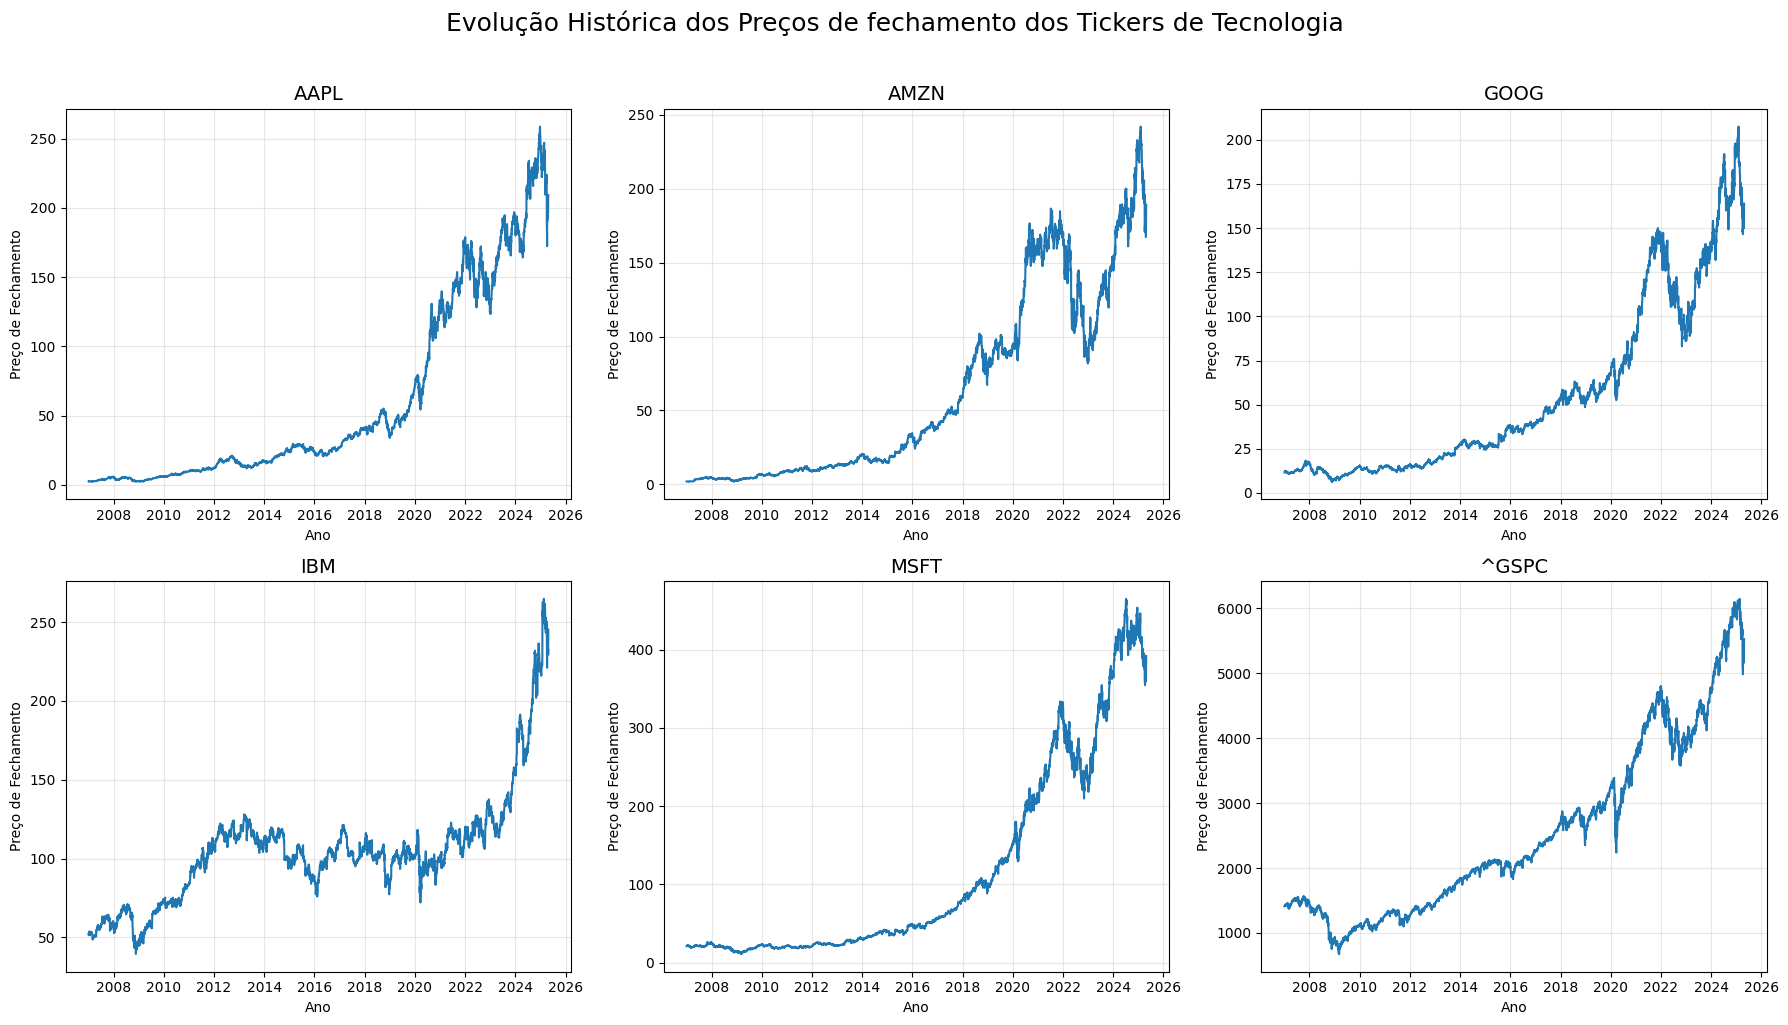

In [26]:
#Análise por ticker
tickers = df_total['ticker'].unique()
tickers = [ticker for ticker in tickers if ticker != 'NFLX']
tickers_painel = tickers[:6]

# Criando um painel de gráficos para os tickers de interesse
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 linhas, 3 colunas
axs = axs.flatten()



for i, ticker in enumerate(tickers_painel):
    df_ticker = df_total[df_total['ticker'] == ticker]
    
    axs[i].plot(df_ticker['Date'], df_ticker['Close'], label=f'{ticker}')
    
    axs[i].set_title(f'{ticker}', fontsize=14)
    axs[i].set_xlabel('Ano')
    axs[i].set_ylabel('Preço de Fechamento')
    
    # Formatar eixo de data
    axs[i].xaxis.set_major_locator(mdates.YearLocator(base=2))  # marca de 2 em 2 anos
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    axs[i].grid(alpha=0.3)

    fig.suptitle('Evolução Histórica dos Preços de fechamento dos Tickers de Tecnologia', fontsize=18, y=1.02)

plt.tight_layout()
plt.show()



📈 EDA para o ativo: AAPL

🔍 Frequência das observações:
Date
1 days    3607
3 days     831
4 days     123
2 days      45
5 days       1
Name: count, dtype: int64


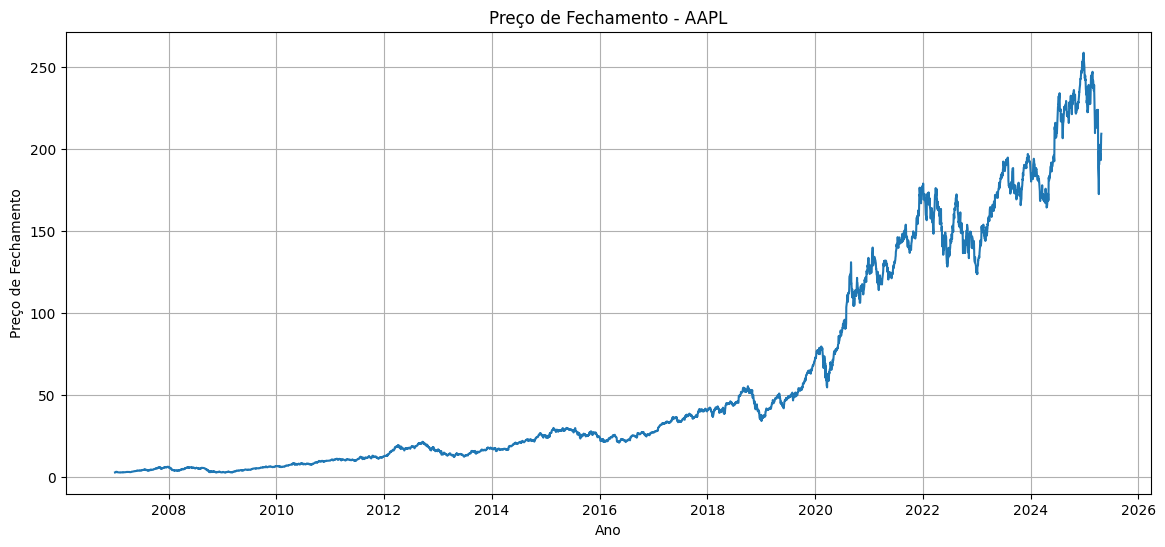


🔍 Teste de Estacionariedade (ADF Test):
ADF Statistic: 0.7480
p-value: 0.9907
⚠️ A série NÃO é estacionária (p-valor > 0.05)


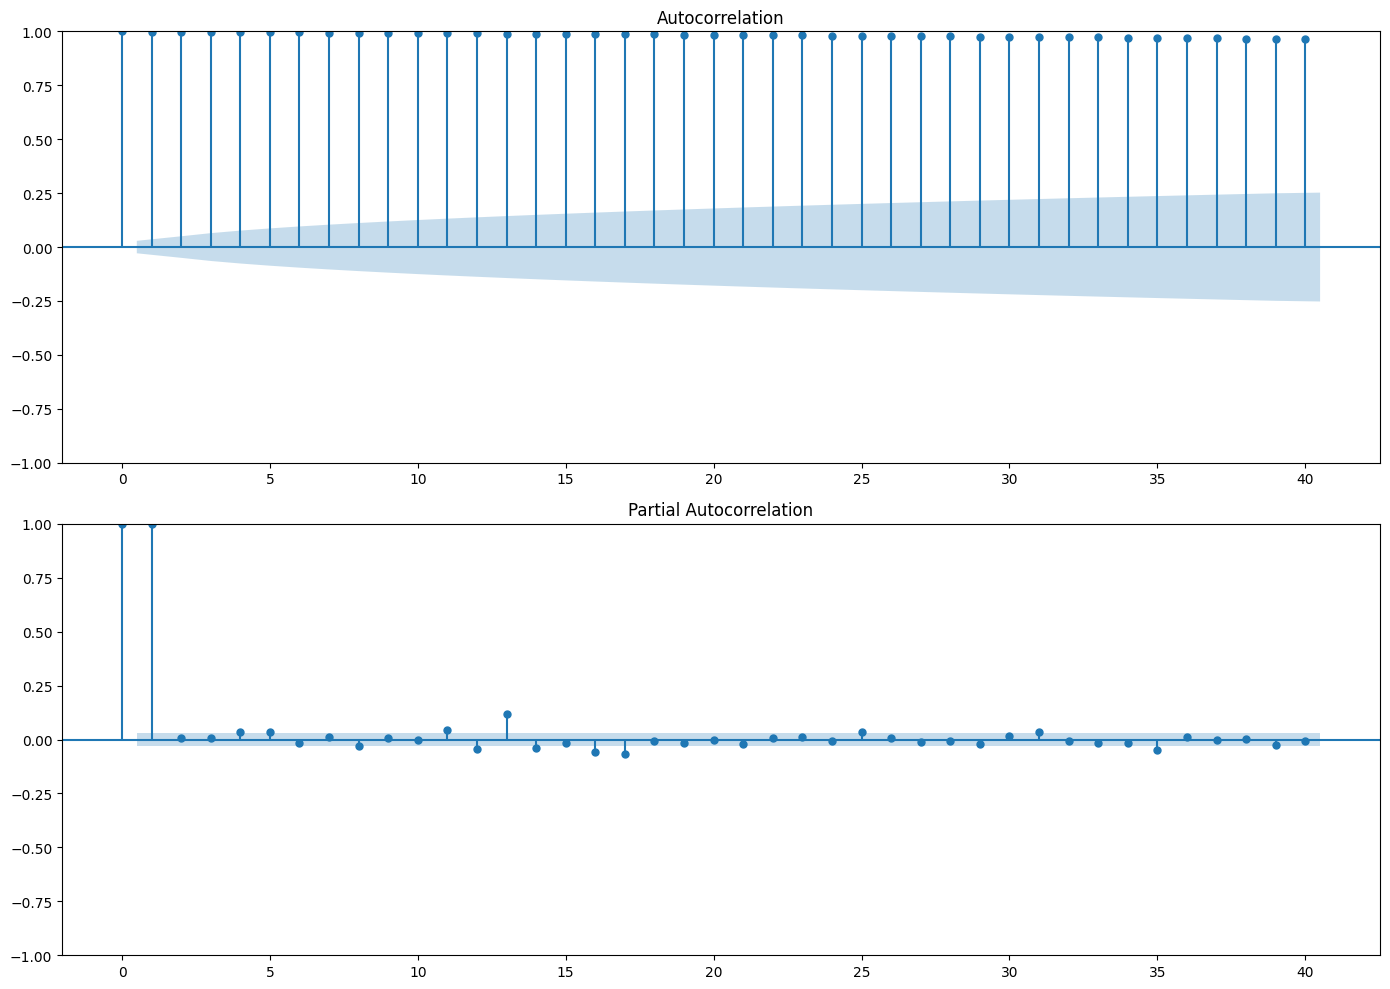



📈 EDA para o ativo: AMZN

🔍 Frequência das observações:
Date
1 days    3607
3 days     831
4 days     123
2 days      45
5 days       1
Name: count, dtype: int64


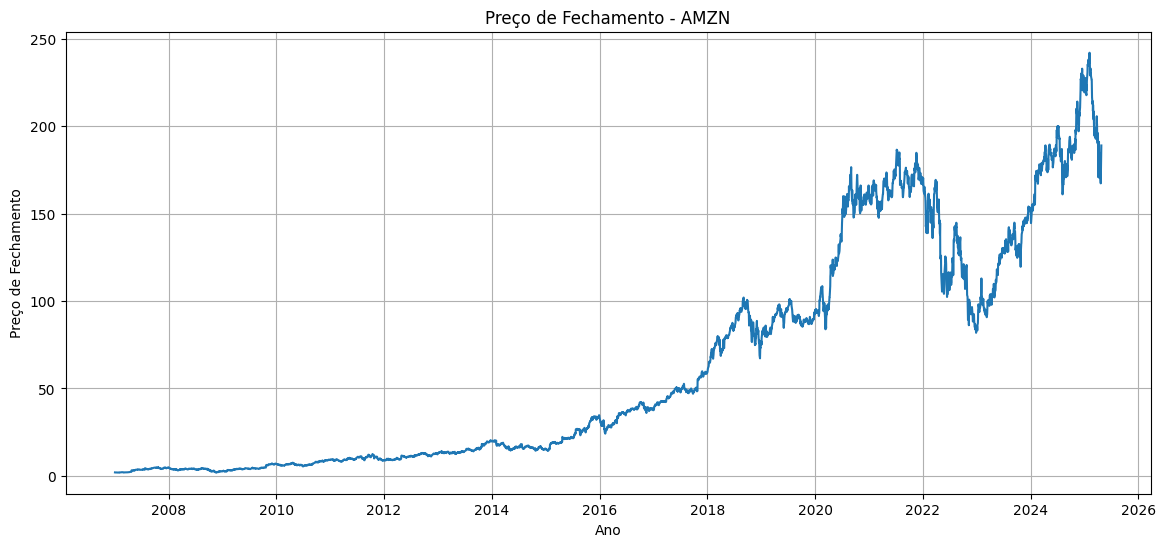


🔍 Teste de Estacionariedade (ADF Test):
ADF Statistic: 0.0013
p-value: 0.9586
⚠️ A série NÃO é estacionária (p-valor > 0.05)


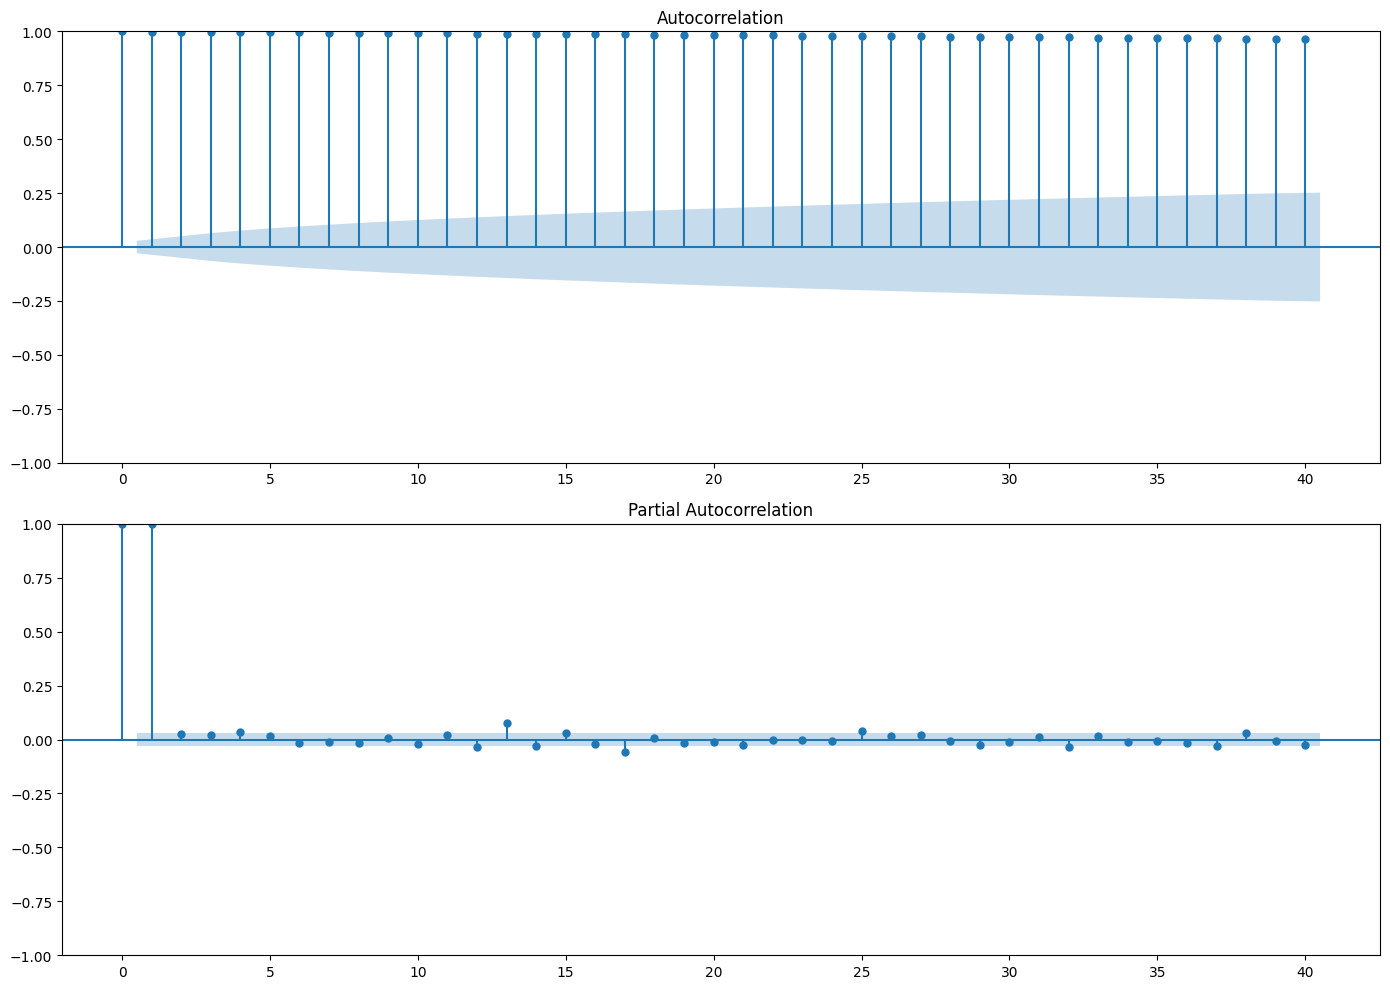



📈 EDA para o ativo: GOOG

🔍 Frequência das observações:
Date
1 days    3607
3 days     831
4 days     123
2 days      45
5 days       1
Name: count, dtype: int64


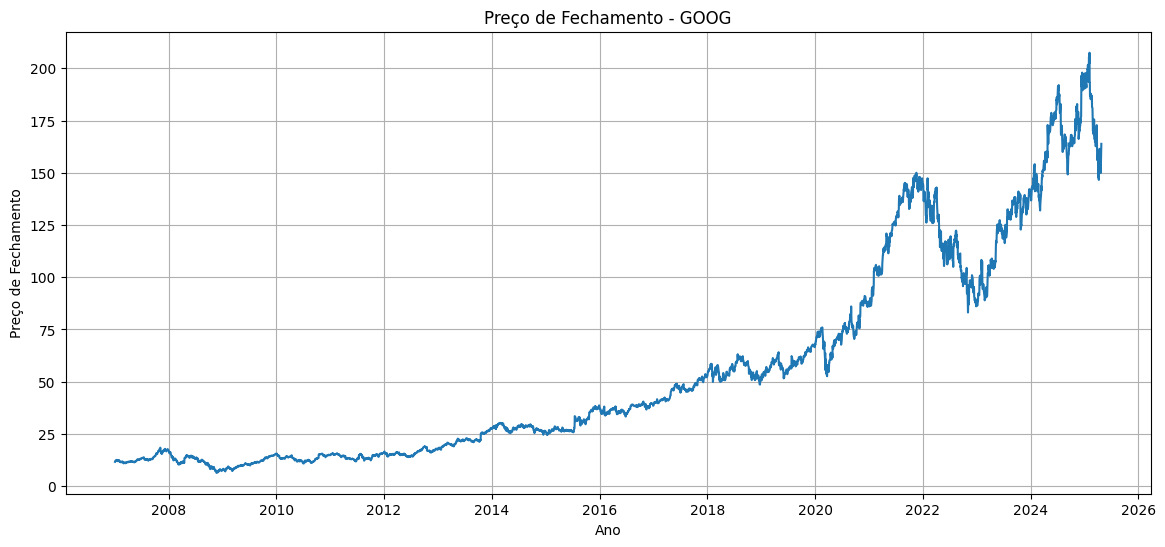


🔍 Teste de Estacionariedade (ADF Test):
ADF Statistic: 0.2385
p-value: 0.9743
⚠️ A série NÃO é estacionária (p-valor > 0.05)


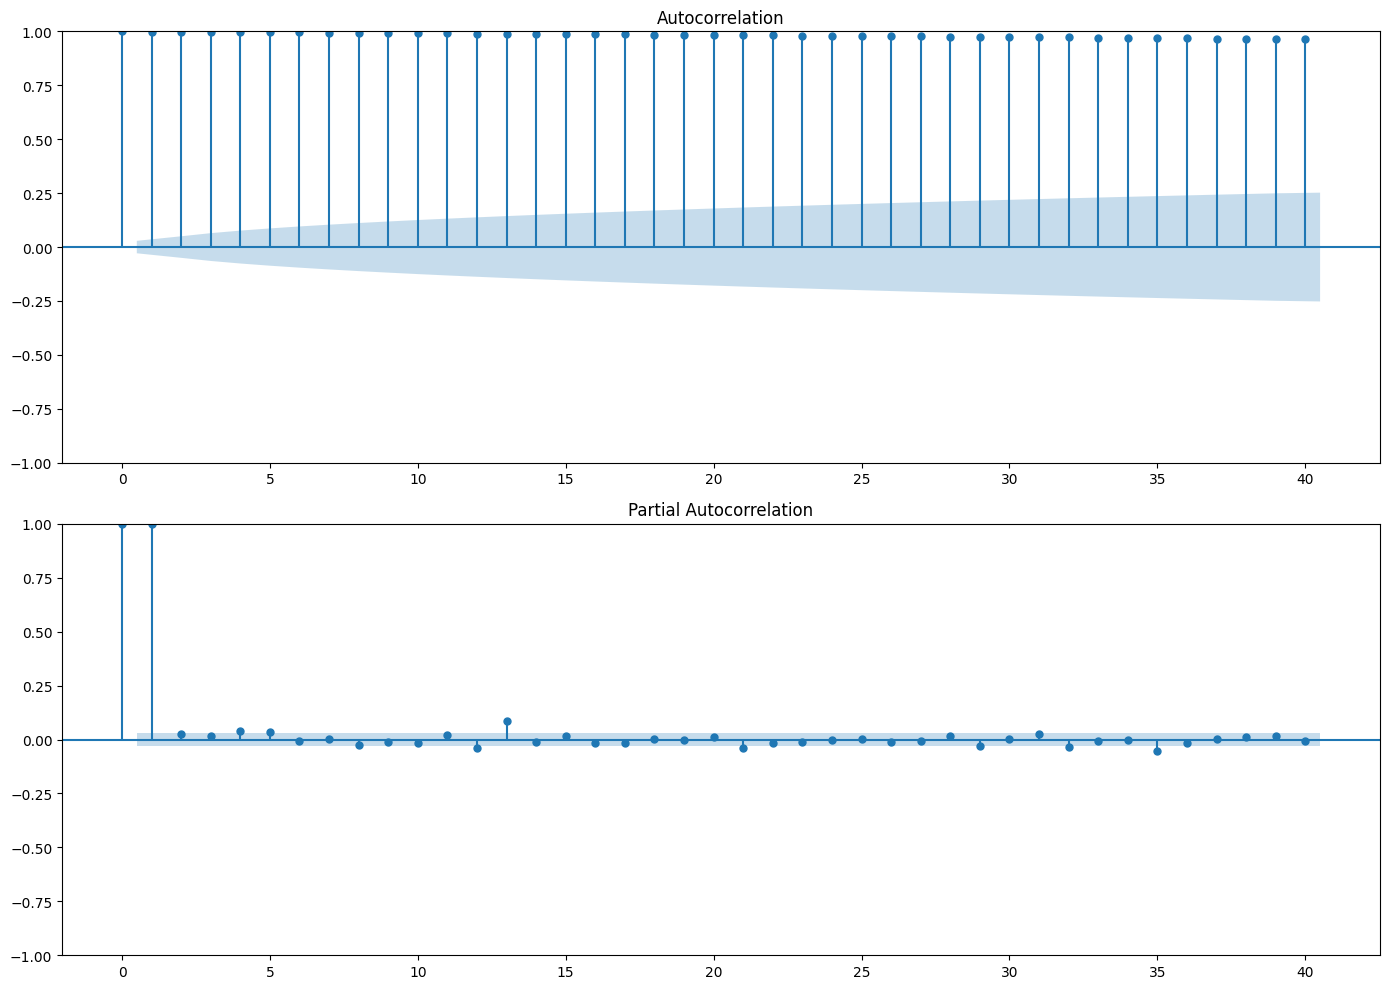



📈 EDA para o ativo: MSFT

🔍 Frequência das observações:
Date
1 days    3607
3 days     831
4 days     123
2 days      45
5 days       1
Name: count, dtype: int64


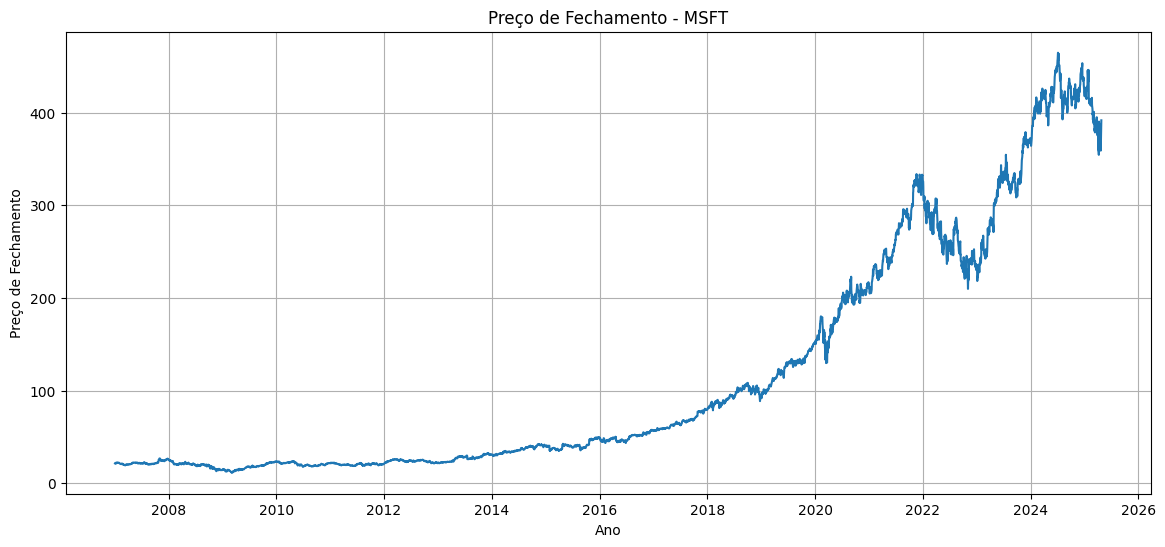


🔍 Teste de Estacionariedade (ADF Test):
ADF Statistic: 1.2213
p-value: 0.9961
⚠️ A série NÃO é estacionária (p-valor > 0.05)


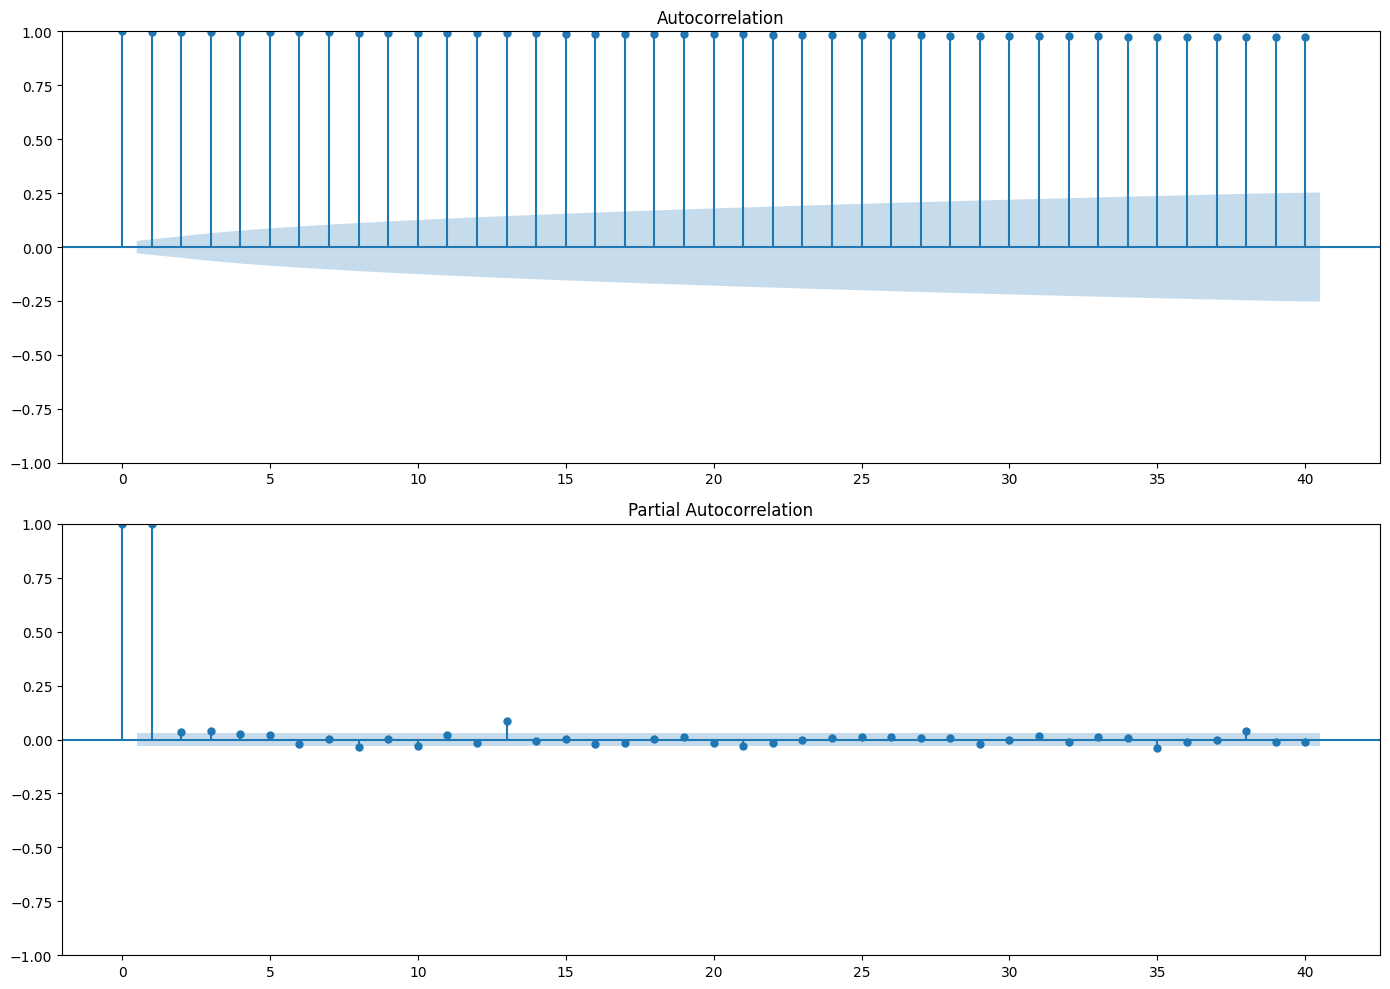



📈 EDA para o ativo: IBM

🔍 Frequência das observações:
Date
1 days    3607
3 days     831
4 days     123
2 days      45
5 days       1
Name: count, dtype: int64


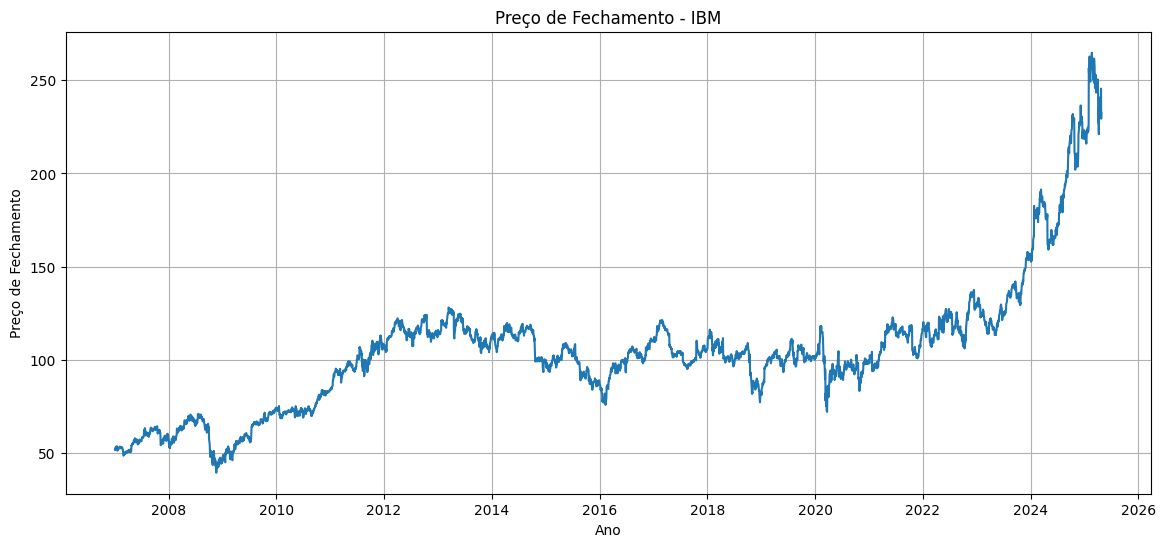


🔍 Teste de Estacionariedade (ADF Test):
ADF Statistic: 0.7940
p-value: 0.9915
⚠️ A série NÃO é estacionária (p-valor > 0.05)


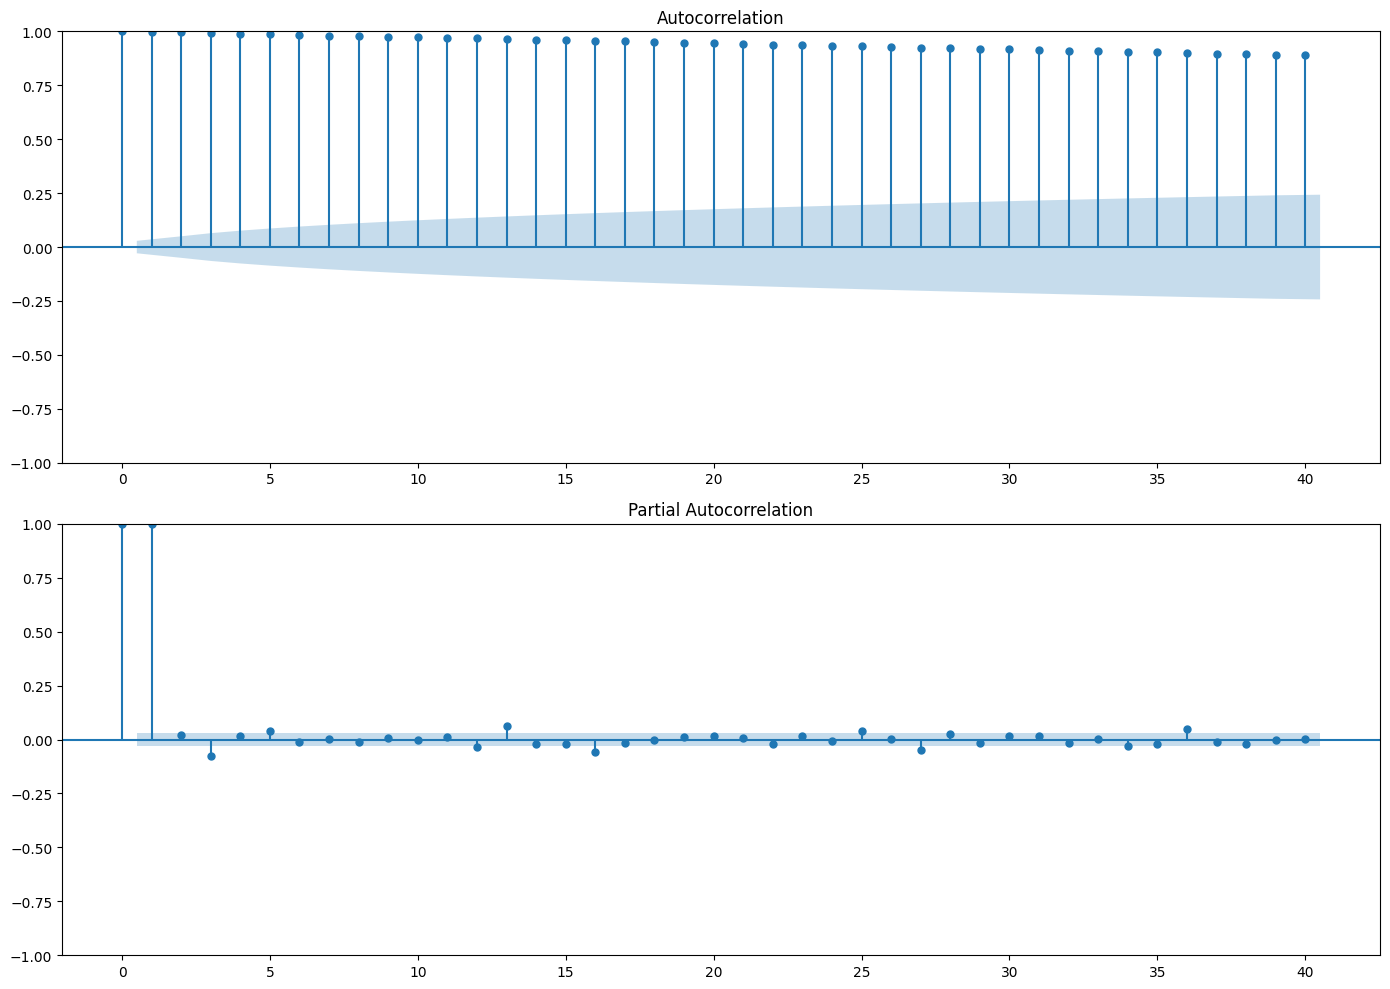



📈 EDA para o ativo: NFLX

🔍 Frequência das observações:
Date
1 days    3607
3 days     831
4 days     123
2 days      45
5 days       1
Name: count, dtype: int64


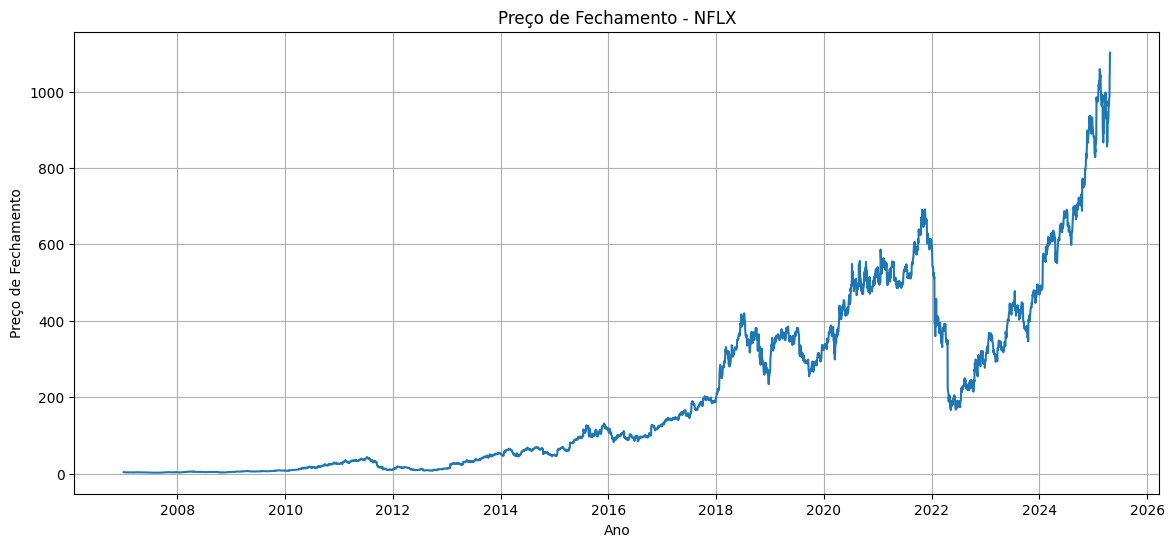


🔍 Teste de Estacionariedade (ADF Test):
ADF Statistic: 2.2481
p-value: 0.9989
⚠️ A série NÃO é estacionária (p-valor > 0.05)


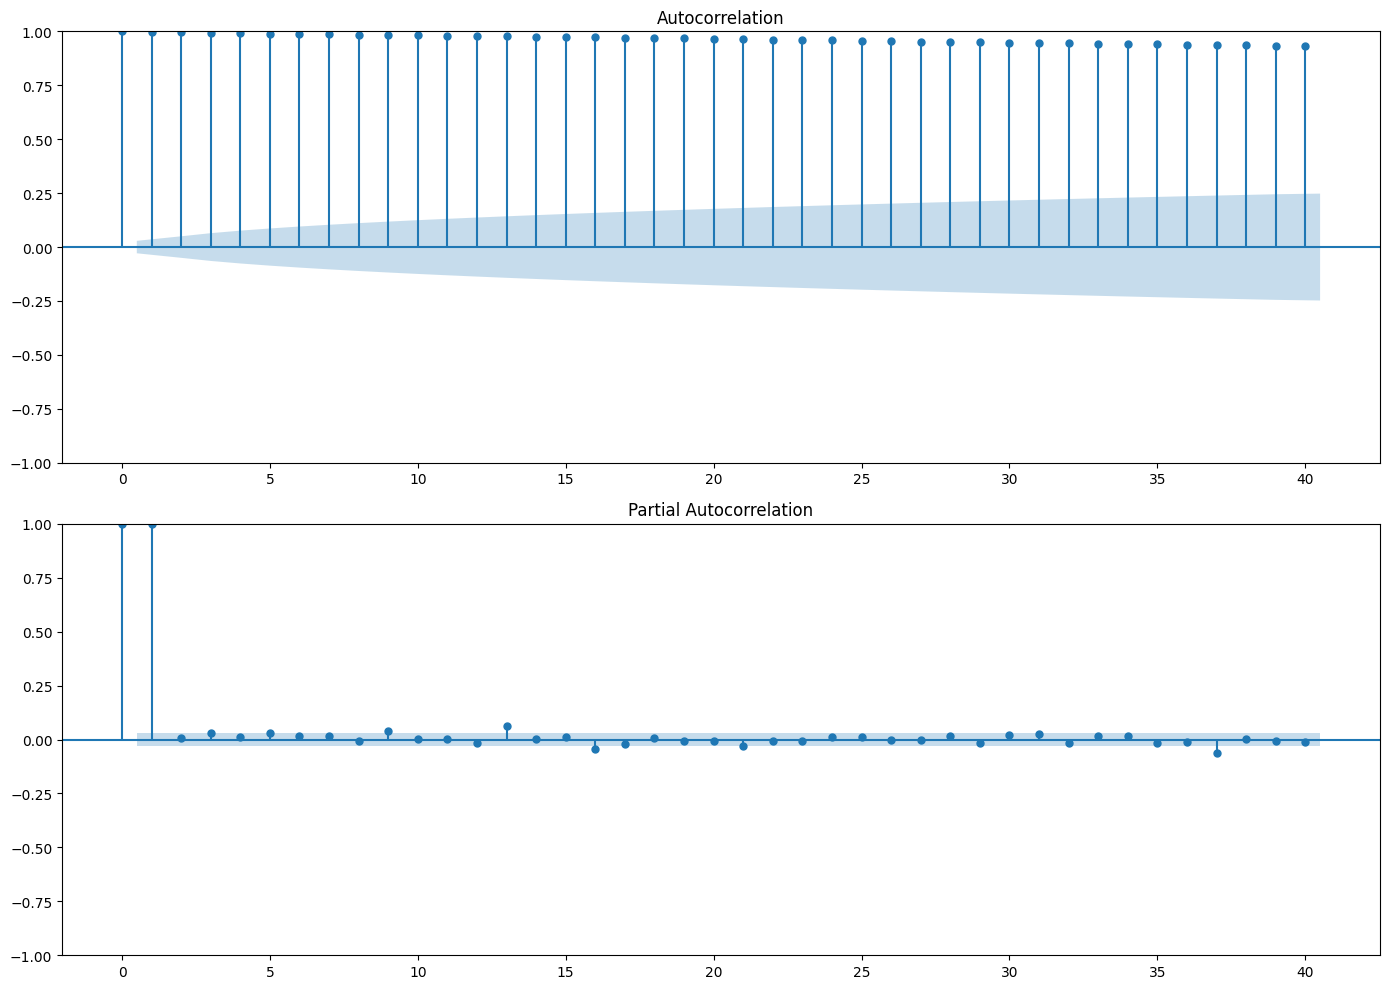

In [49]:

# 2. Definir 'Date' como índice e ordenar
df_total = df_total.set_index('Date')
df_total = df_total.sort_index()

# 3. Função para análise de um ticker específico
def eda_serie_temporal(df, ticker):
    print(f"\n\n📈 EDA para o ativo: {ticker}")
    df_ticker = df[df['ticker'] == ticker]

    # 3.1 Checar frequência
    print("\n🔍 Frequência das observações:")
    print(df_ticker.index.to_series().diff().value_counts())

    # 3.2 Visualizar Série Temporal
    plt.figure(figsize=(14,6))
    plt.plot(df_ticker.index, df_ticker['Close'])
    plt.title(f'Preço de Fechamento - {ticker}')
    plt.xlabel('Ano')
    plt.ylabel('Preço de Fechamento')
    plt.grid()
    plt.show()

    # 3.3 Teste de Estacionariedade (Dickey-Fuller)
    print("\n🔍 Teste de Estacionariedade (ADF Test):")
    result = adfuller(df_ticker['Close'].dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("✅ A série é estacionária (p-valor < 0.05)")
    else:
        print("⚠️ A série NÃO é estacionária (p-valor > 0.05)")

    # 3.4 Plotar Autocorrelação e Autocorrelação Parcial
    fig, ax = plt.subplots(2, 1, figsize=(14,10))
    plot_acf(df_ticker['Close'].dropna(), lags=40, ax=ax[0])
    plot_pacf(df_ticker['Close'].dropna(), lags=40, ax=ax[1])
    plt.tight_layout()
    plt.show()

# 4. Rodar para todos os tickers principais
tickers_para_analise = [ticker for ticker in df_total['ticker'].unique() if ticker != '^GSPC']  # tirando o benchmark

for ticker in tickers_para_analise:
    eda_serie_temporal(df_total, ticker)


A otimização de portfólio trabalha diretamente com os retornos diários (Return), não com os preços (Close).

Retornos já são naturalmente muito mais estacionários que preços.

Modelos como a Teoria Moderna de Portfólio (Markowitz) assumem que:

Retornos são aleatórios, mas razoavelmente estacionários.

Não há problema se os retornos tiverem pequenas autocorrelações.

### Calculando o retorno 

In [28]:
df_total = df_total.sort_values(['ticker', 'Date'])
df_total['Return'] = df_total.groupby('ticker')['Close'].pct_change()


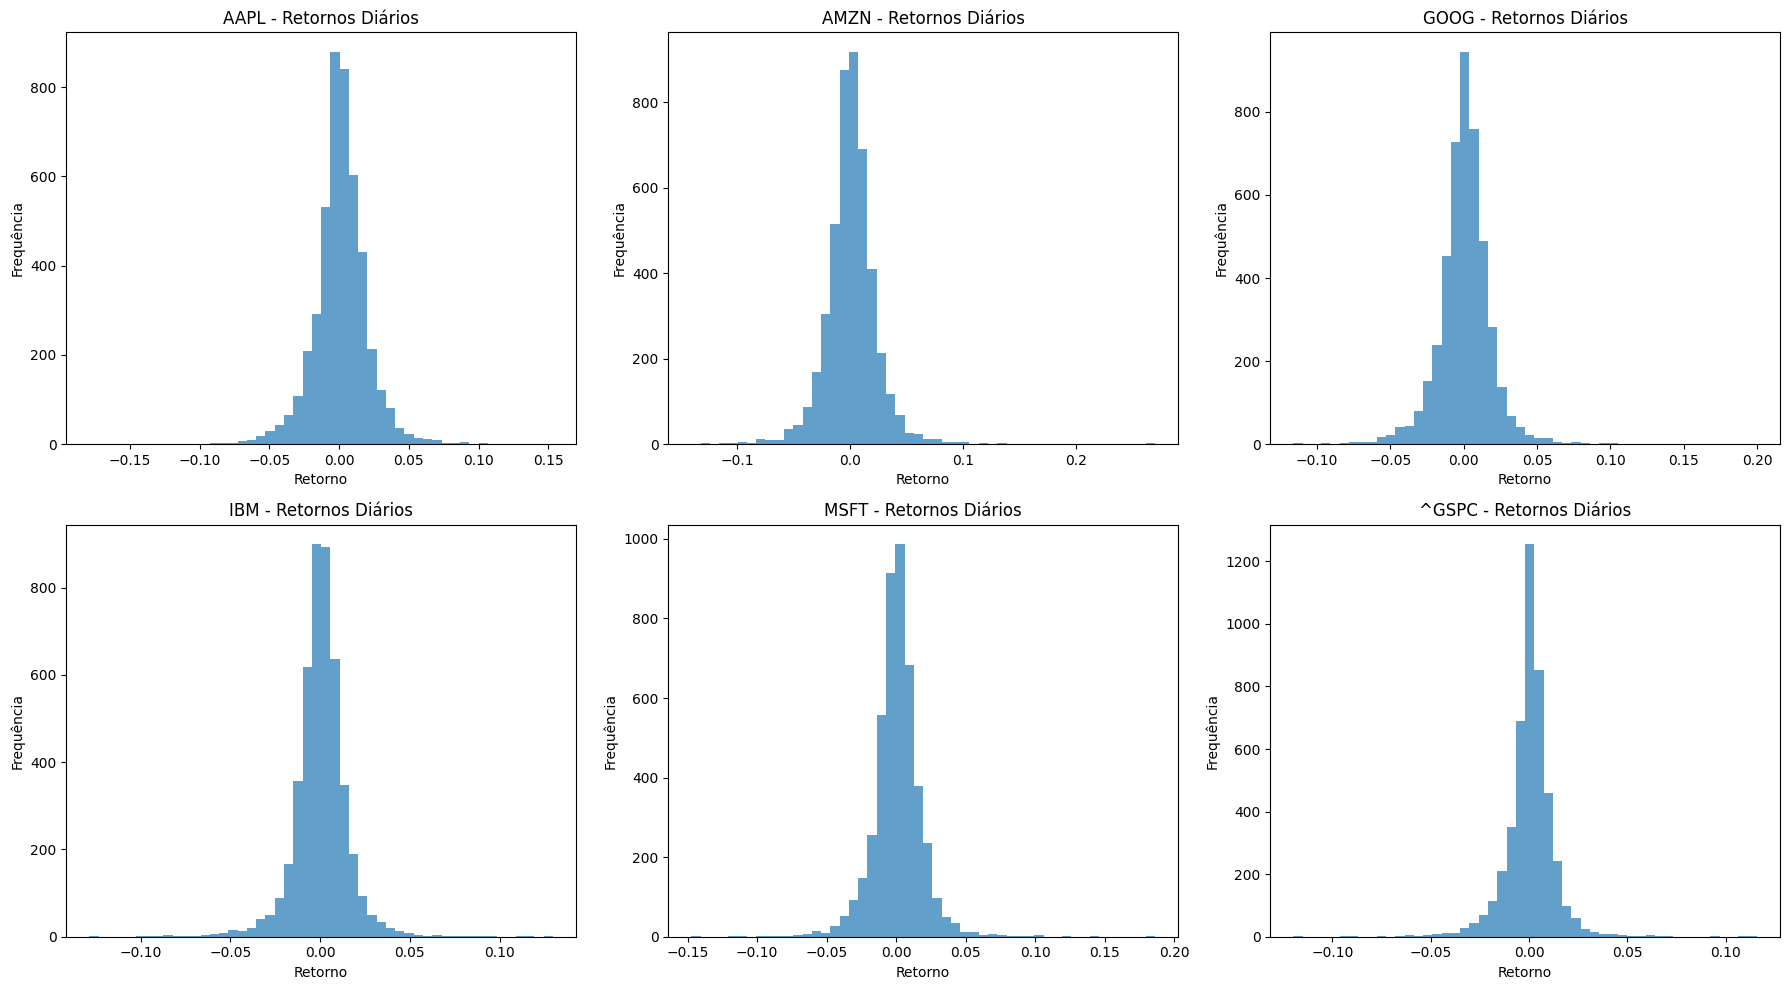

  ticker  media_retorno  volatilidade  retorno_acumulado
0   AAPL       0.001159      0.019950          81.986888
1   AMZN       0.001277      0.023942          96.669256
2   GOOG       0.000750      0.018768          13.135728
3    IBM       0.000438      0.014984           3.484386
4   MSFT       0.000789      0.017680          17.452762
5   NFLX       0.001740      0.031849         288.767353
6  ^GSPC       0.000376      0.012666           2.900332


In [ ]:
# 1. PREPARO
df_total = df_total.sort_values(['ticker', 'Date'])
df_total['Return'] = df_total.groupby('ticker')['Close'].pct_change()

# 2. ANÁLISE DE RETORNOS
# 2.1 Histogramas dos retornos
tickers = df_total['ticker'].unique()
tickers = [ticker for ticker in tickers if ticker != 'NFLX']
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, ticker in enumerate(tickers[:6]):  # Assume que você tirou o NFLX
    df_ticker = df_total[df_total['ticker'] == ticker]
    axs[i].hist(df_ticker['Return'].dropna(), bins=50, alpha=0.7)
    axs[i].set_title(f'{ticker} - Retornos Diários')
    axs[i].set_xlabel('Retorno')
    axs[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# 2.2 Estatísticas resumo
summary = df_total.groupby('ticker').agg(
    media_retorno=('Return', 'mean'),
    volatilidade=('Return', 'std'),
    retorno_acumulado=('Return', lambda x: (1 + x).prod() - 1)
).reset_index()

print(summary)




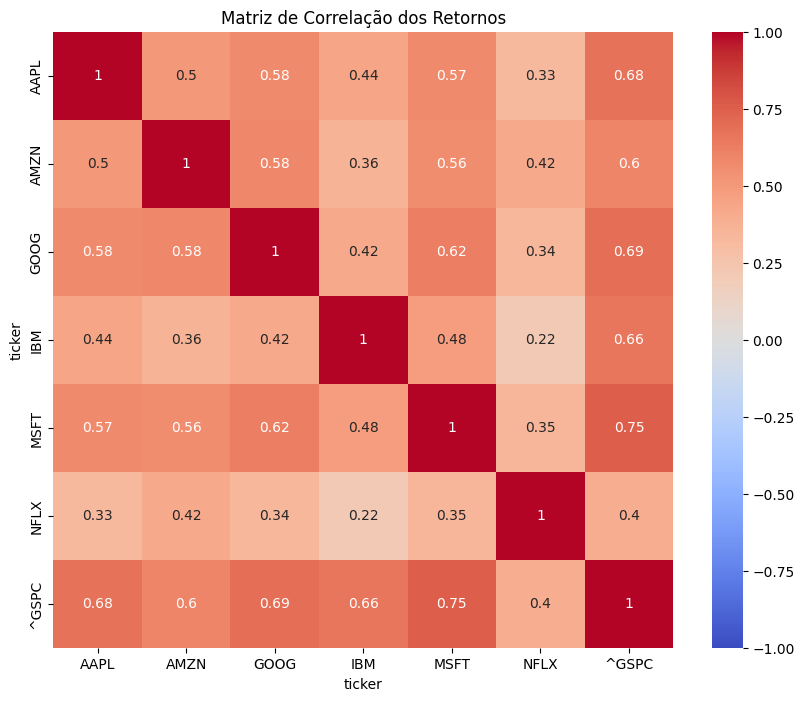

In [ ]:
#"A matriz de covariância dos retornos é fundamental para entender a dinâmica de risco conjunto entre os ativos. \
# Ao utilizar essas informações, conseguimos construir portfólios mais eficientes, otimizando o equilíbrio entre \
# risco e retorno."


# 3. CORRELAÇÃO DOS ATIVOS
# Pivotar a base para ter tickers como colunas
returns_pivot = df_total.pivot(index='Date', columns='ticker', values='Return')

# Matriz de correlação
correlation_matrix = returns_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação dos Retornos')
plt.show()


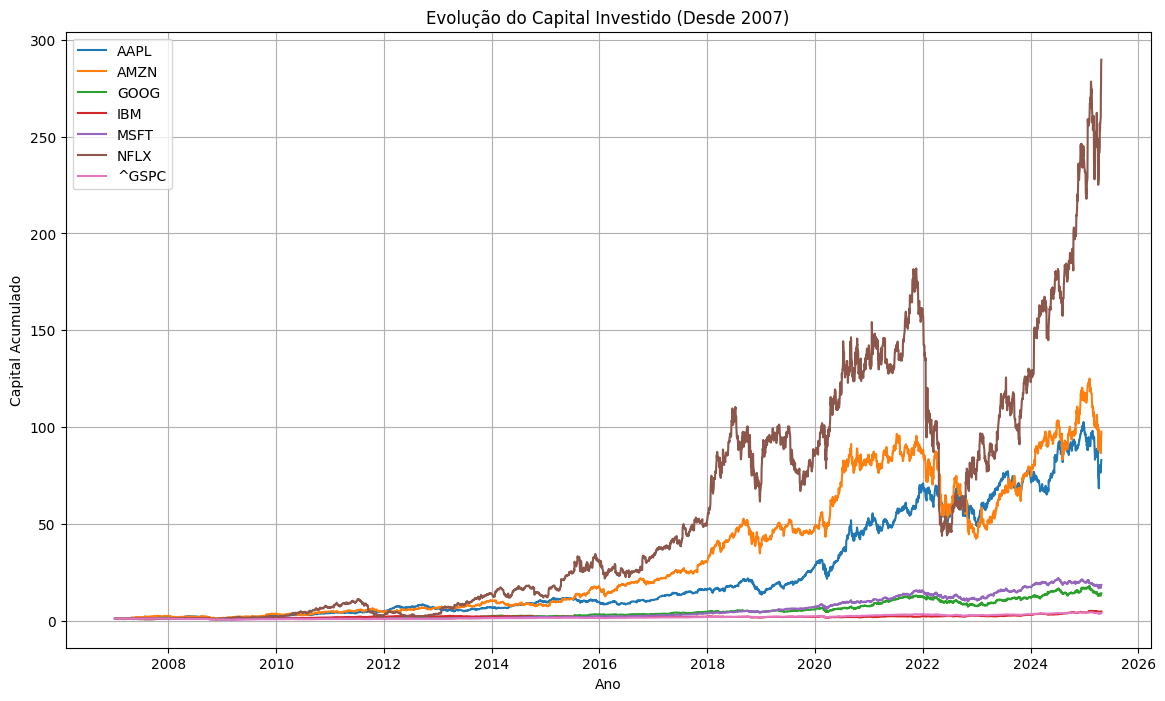

In [31]:
# 4. EVOLUÇÃO DO CAPITAL (Retorno acumulado no tempo)
# Cálculo do capital acumulado (investimento inicial = 1 unidade)
capital = (1 + returns_pivot).cumprod()

plt.figure(figsize=(14,8))
for ticker in capital.columns:
    plt.plot(capital.index, capital[ticker], label=ticker)

plt.title('Evolução do Capital Investido (Desde 2007)')
plt.xlabel('Ano')
plt.ylabel('Capital Acumulado')
plt.legend()
plt.grid(True)
plt.show()


## Modelagem - Otimização de Portfólio

In [37]:
# Pivotar os retornos para ter tickers como colunas
returns_pivot = df_total.pivot(index='Date', columns='ticker', values='Return')

# Separar benchmark de mercado
benchmark_returns = returns_pivot['^GSPC']

# Remover ^GSPC dos dados para otimização
returns_pivot = returns_pivot.drop(columns=['^GSPC'])

# Retorno médio esperado (média dos retornos diários)
mean_returns = returns_pivot.mean()

# Matriz de covariância dos retornos
cov_matrix = returns_pivot.cov()


In [38]:
import numpy as np

def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calcula retorno esperado e volatilidade de um portfólio dado os pesos."""
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    """Função objetivo: Sharpe Ratio negativo (para minimizar)."""
    returns, std = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (returns - risk_free_rate) / std
    return -sharpe_ratio  # Queremos maximizar o Sharpe Ratio, então minimizamos o negativo

def check_sum(weights):
    """Retorna 0 se a soma dos pesos for 1 (restrição)."""
    return np.sum(weights) - 1


In [39]:
from scipy.optimize import minimize

# Número de ativos
num_assets = len(mean_returns)

# Pesos iniciais (chute inicial, divisão igualitária)
initial_weights = num_assets * [1. / num_assets]

# Restrições: soma dos pesos tem que ser 1
constraints = ({'type': 'eq', 'fun': check_sum})

# Limites: cada peso entre 0 e 1 (não vendemos a descoberto aqui)
bounds = tuple((0, 1) for asset in range(num_assets))

# Rodar otimização
optimized = minimize(
    negative_sharpe,
    initial_weights,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Pesos ótimos encontrados
optimal_weights = optimized.x


In [41]:
# 4. PERFORMANCE DA CARTEIRA OTIMIZADA

# Construir série de capital
optimized_returns = (returns_pivot * optimal_weights).sum(axis=1)
optimized_capital = (1 + optimized_returns).cumprod()

# Capital do benchmark
benchmark_capital = (1 + benchmark_returns).cumprod()

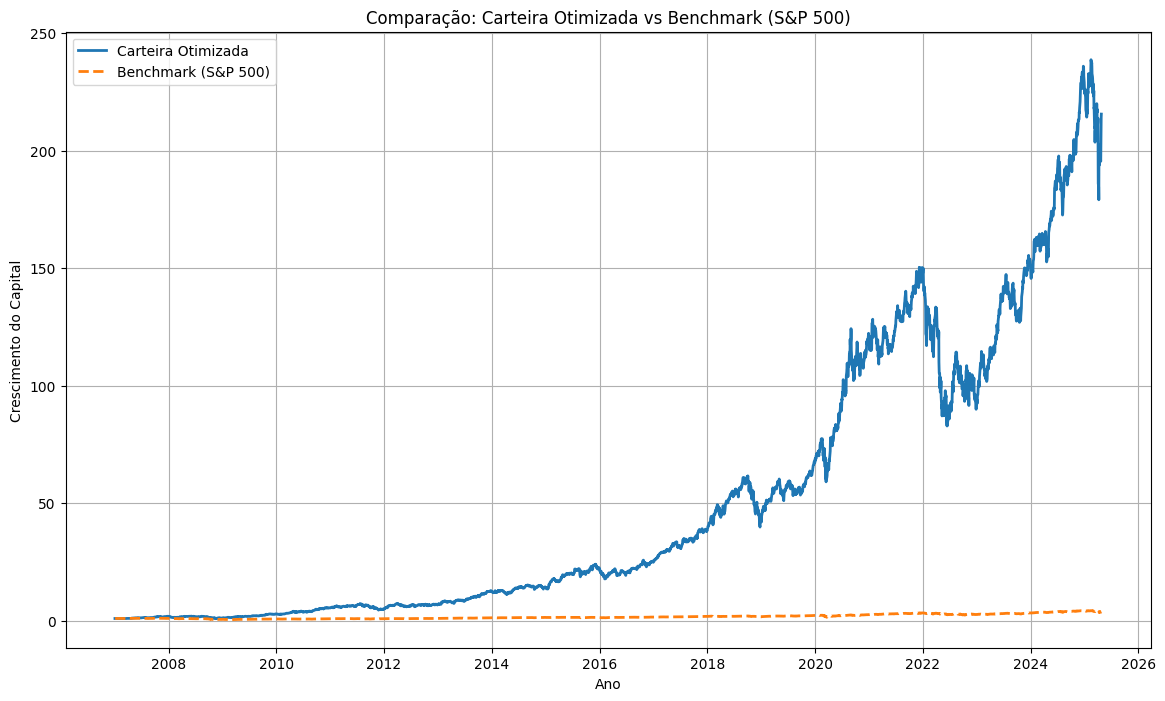

In [42]:
# 5. PLOTAR COMPARAÇÃO

plt.figure(figsize=(14,8))
plt.plot(optimized_capital.index, optimized_capital, label='Carteira Otimizada', linewidth=2)
plt.plot(benchmark_capital.index, benchmark_capital, label='Benchmark (S&P 500)', linewidth=2, linestyle='--')

plt.title('Comparação: Carteira Otimizada vs Benchmark (S&P 500)')
plt.xlabel('Ano')
plt.ylabel('Crescimento do Capital')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Organizar pesos em DataFrame
portfolio = pd.DataFrame({
    'Ticker': mean_returns.index,
    'Peso Ótimo': optimal_weights
})

# Calcular desempenho do portfólio
expected_return, expected_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
sharpe_ratio = (expected_return - 0) / expected_std  # Considerando taxa livre de risco = 0

print(portfolio)
print(f"\nRetorno esperado do portfólio: {expected_return:.2%}")
print(f"Volatilidade do portfólio: {expected_std:.2%}")
print(f"Sharpe Ratio do portfólio: {sharpe_ratio:.2f}")


  Ticker    Peso Ótimo
0   AAPL  4.820977e-01
1   AMZN  2.239435e-01
2   GOOG  3.794708e-18
3    IBM  1.301043e-18
4   MSFT  1.228578e-02
5   NFLX  2.816730e-01

Retorno esperado do portfólio: 0.13%
Volatilidade do portfólio: 1.88%
Sharpe Ratio do portfólio: 0.07


In [44]:
# 1. Cálculo do Retorno e Volatilidade da Carteira
optimized_total_return = optimized_capital.iloc[-1] - 1
optimized_volatility = optimized_returns.std() * np.sqrt(252)  # anualizando
optimized_sharpe = (optimized_returns.mean() * 252) / optimized_volatility  # anualizando

# 2. Cálculo do Retorno e Volatilidade do Benchmark
benchmark_total_return = benchmark_capital.iloc[-1] - 1
benchmark_volatility = benchmark_returns.std() * np.sqrt(252)  # anualizando
benchmark_sharpe = (benchmark_returns.mean() * 252) / benchmark_volatility  # anualizando

# 3. Montar a tabela comparativa
comparison = pd.DataFrame({
    'Métrica': ['Retorno Acumulado', 'Volatilidade', 'Sharpe Ratio'],
    'Carteira Otimizada': [f"{optimized_total_return:.2%}", f"{optimized_volatility:.2%}", f"{optimized_sharpe:.2f}"],
    'Benchmark (S&P 500)': [f"{benchmark_total_return:.2%}", f"{benchmark_volatility:.2%}", f"{benchmark_sharpe:.2f}"]
})

print("\nComparação da Carteira Otimizada vs Benchmark:")
print(comparison)



Comparação da Carteira Otimizada vs Benchmark:
             Métrica Carteira Otimizada Benchmark (S&P 500)
0  Retorno Acumulado          21450.91%             290.03%
1       Volatilidade             29.91%              20.11%
2       Sharpe Ratio               1.13                0.47


A carteira otimizada gerou um crescimento de capital substancialmente maior do que o benchmark, aceitando um nível de volatilidade mais elevado, mas mantendo um Sharpe Ratio significativamente superior. Isso comprova que a otimização de pesos baseada na maximização do Sharpe Ratio proporcionou um portfólio altamente eficiente em termos de risco-retorno.

In [ ]:
#Alpha mede o excesso de retorno da sua carteira acima do benchmark, ajustado ao risco

#Beta mede a sensibilidade da sua carteira em relação ao benchmark



In [47]:
# Calculo do Alpha

from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Organizar os dados
# Vamos alinhar os retornos diários (sem NA)
combined_returns = pd.concat([optimized_returns, benchmark_returns], axis=1).dropna()
combined_returns.columns = ['Portfolio', 'Benchmark']

# 2. Ajustar a regressão linear: Portfolio = alpha + beta * Benchmark + erro
X = combined_returns['Benchmark'].values.reshape(-1, 1)
y = combined_returns['Portfolio'].values

reg = LinearRegression().fit(X, y)
beta = reg.coef_[0]
alpha = reg.intercept_

# 3. Mostrar os resultados
print(f"\nBeta da carteira em relação ao benchmark: {beta:.4f}")
print(f"Alpha da carteira em relação ao benchmark: {alpha*252:.2%} (anualizado)")



Beta da carteira em relação ao benchmark: 1.0628
Alpha da carteira em relação ao benchmark: 23.82% (anualizado)


Beta mede a sensibilidade da carteira aos movimentos do mercado.:  levemente mais volátil do que o benchmark (S&P 500).
Alpha mede o excesso de retorno ajustado ao risco.: A carteira gerou 23,82% a mais de retorno anual do que o esperado, dado o nivel de risco (Beta de 1,06).
A carteira otimizada apresentou um Beta de 1,06, indicando uma volatilidade levemente superior ao mercado. Contudo, o Alpha anualizado de 23,82% demonstra que a estratégia não apenas compensou o risco adicional, como também superou amplamente o benchmark. Esses resultados confirmam que a otimização foi eficiente em maximizar o retorno ajustado ao risco.

In [ ]:
# Calculo do Alpha

from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Organizar os dados
# Vamos alinhar os retornos diários (sem NA)
combined_returns = pd.concat([optimized_returns, benchmark_returns], axis=1).dropna()
combined_returns.columns = ['Portfolio', 'Benchmark']

# 2. Ajustar a regressão linear: Portfolio = alpha + beta * Benchmark + erro
X = combined_returns['Benchmark'].values.reshape(-1, 1)
y = combined_returns['Portfolio'].values

reg = LinearRegression().fit(X, y)
beta = reg.coef_[0]
alpha = reg.intercept_

# 3. Mostrar os resultados
print(f"\nBeta da carteira em relação ao benchmark: {beta:.4f}")
print(f"Alpha da carteira em relação ao benchmark: {alpha*252:.2%} (anualizado)")



Beta da carteira em relação ao benchmark: 1.0628
Alpha da carteira em relação ao benchmark: 23.82% (anualizado)
